# Initialize Environment

In [31]:
from dotenv import load_dotenv
load_dotenv()

True

In [55]:
import numpy as np
import pandas as pd
# ensure kaggle api credentials available via .env
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import shutil
import plotnine as p9
import scipy.special as ssp

In [33]:
DATA_NEEDS_DOWNLOADED = False

# Extract Data

In [34]:
if DATA_NEEDS_DOWNLOADED:

    # expected workflow, though authentication issues persist
    # api = KaggleApi()
    # api.authenticate()
    # api.competition_download_file("dont-get-kicked", "training.csv", path="./data/dont_get_kicked")

    os.system('kaggle competitions download -c DontGetKicked')
    shutil.unpack_archive("DontGetKicked.zip", "./data")
    os.remove("DontGetKicked.zip")

In [35]:
df_train = pd.read_csv("./data/training.csv")
df_test = pd.read_csv("./data/test.csv")

In [36]:
print(df_train.shape)
print(df_test.shape)

(72983, 34)
(48707, 33)


In [37]:
df_train.head().transpose()

,0,1,2,3,4
RefId,1,2,3,4,5
IsBadBuy,0,0,0,0,0
PurchDate,12/7/2009,12/7/2009,12/7/2009,12/7/2009,12/7/2009
Auction,ADESA,ADESA,ADESA,ADESA,ADESA
VehYear,2006,2004,2005,2004,2005
VehicleAge,3,5,4,5,4
Make,MAZDA,DODGE,DODGE,DODGE,FORD
Model,MAZDA3,1500 RAM PICKUP 2WD,STRATUS V6,NEON,FOCUS
Trim,i,ST,SXT,SXT,ZX3
SubModel,4D SEDAN I,QUAD CAB 4.7L SLT,4D SEDAN SXT FFV,4D SEDAN,2D COUPE ZX3


# Analyze

## Build Intuition through Visual

In [38]:
N_BINS = 10

In [39]:
q_x = df_train['VehOdo']
n_q = df_train.shape[0]

p_x = df_test['VehOdo']
n_p = df_test.shape[0]

In [40]:
q = np.histogram(q_x, bins=N_BINS)

In [41]:
q

(array([   22,   145,   919,  5050, 10124, 16298, 22200, 15243,  2807,
          175], dtype=int64),
 array([  4825. ,  15914.2,  27003.4,  38092.6,  49181.8,  60271. ,
         71360.2,  82449.4,  93538.6, 104627.8, 115717. ]))

In [42]:
df_q = pd.DataFrame({
    'n': q[0],
    'prb': q[0] / n_q,
    'series': 'Train'
})
df_q['bin'] = df_q.index.values

In [43]:
p = np.histogram(p_x, bins=q[1])

In [44]:
p

(array([   29,   121,   672,  3203,  6433, 11176, 14937, 10334,  1672,
          126], dtype=int64),
 array([  4825. ,  15914.2,  27003.4,  38092.6,  49181.8,  60271. ,
         71360.2,  82449.4,  93538.6, 104627.8, 115717. ]))

In [45]:
df_p = pd.DataFrame({
    'n': p[0],
    'prb': p[0] / n_p,
    'series': 'Test'
})
df_p['bin'] = df_p.index.values

In [46]:
compare_p_q = pd.concat([df_q, df_p], axis=0)

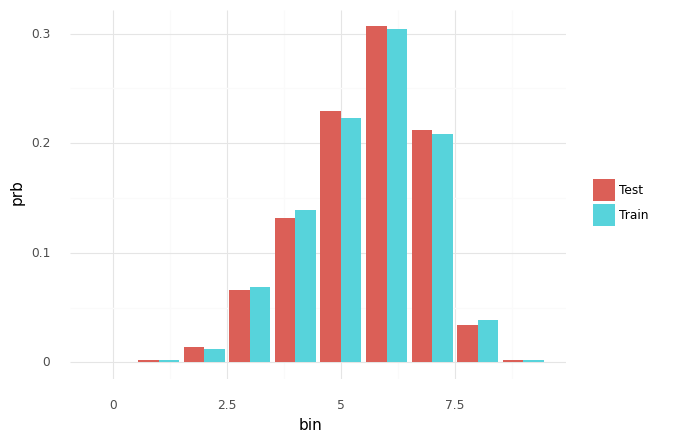

<ggplot: (140180549937)>

In [53]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('bin', 'prb', fill='series'), position='dodge') + 
    p9.labs(fill='')
)

## Naive Statistical Test

In [59]:
ssp.rel_entr(p[0] / n_p, q[0] / n_q).sum()

0.0007486716020464318

In [68]:
def sample_kl_divergence(q_x, n_bins, nobs_monitoring_window):

    p_x_sample = np.random.choice(q_x, size=nobs_monitoring_window, replace=True)

    q = np.histogram(q_x, bins=n_bins)
    p = np.histogram(p_x_sample, bins=q[1])

    kl_div = ssp.rel_entr(
        q[0] / q[0].sum(), 
        p[0] / nobs_monitoring_window
        ).sum()

    return kl_div

In [69]:
NOBS_MONITORING_WINDOW = df_test.shape[0]
N_SAMPLING_DISTR_DRAWS = 1000

kl_div = [
    sample_kl_divergence(q_x, N_BINS, NOBS_MONITORING_WINDOW)
    for i in range(N_SAMPLING_DISTR_DRAWS)
]

In [70]:
sum(0.0007486716020464318 > np.array(kl_div))

1000

In [71]:
np.quantile(kl_div, q = [0.1, 0.25, 0.5, 0.75, 0.9])

array([3.98251406e-05, 5.91273424e-05, 8.57036091e-05, 1.18046031e-04,
       1.51737049e-04])

## "Regularized" Statistical Test

In [76]:
NOBS_MONITORING_WINDOW = 10000
N_SAMPLING_DISTR_DRAWS = 1000

kl_div = [
    sample_kl_divergence(q_x, N_BINS, NOBS_MONITORING_WINDOW)
    for i in range(N_SAMPLING_DISTR_DRAWS)
]

In [77]:
sum(0.0007486716020464318 > np.array(kl_div))

885